In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import r2_score
import pickle
from bayesian_logistic_regression import BayesianLogisticRegression
from mlba_mdn import MLBA_MDN
import json

In [17]:
features = ['Rect1Height', 'Rect1Width', 'Rect2Height', 'Rect2Width', 'Rect3Height', 'Rect3Width']
train_data = pd.read_csv('data/E2.csv')
e1a = pd.read_csv('data/E1a.csv')
e1b = pd.read_csv('data/E1b.csv')
e1c = pd.read_csv('data/E1c.csv')

## Train a model

In [18]:
X_train = train_data[features].values
y_train = train_data.response.values - 1
# model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# model = RandomForestClassifier(n_estimators=100)
# model = tree.DecisionTreeClassifier(max_depth=5)
# model = SVC(probability=True, gamma='auto')
# model = BayesianLogisticRegression(10000)
model = MLBA_MDN(6, 3, 50, 100, 32)
model = model.fit(X_train, y_train)
# model.save('bayes_logistic.pkl')
# model.load('bayes_logistic.pkl')

Tue Aug 11 14:44:54 2020 >  Epoch     5 - Train Loss:     1.022371, val Loss:   1.023395, Best:   1.023395
Tue Aug 11 14:44:58 2020 >  Epoch    10 - Train Loss:     1.018127, val Loss:   1.013421, Best:   1.013272
Tue Aug 11 14:45:03 2020 >  Epoch    15 - Train Loss:     1.017150, val Loss:   1.011889, Best:   1.011889
Tue Aug 11 14:45:08 2020 >  Epoch    20 - Train Loss:     1.016105, val Loss:   1.009522, Best:   1.009439
Tue Aug 11 14:45:12 2020 >  Epoch    25 - Train Loss:     1.015720, val Loss:   1.008921, Best:   1.008921
Tue Aug 11 14:45:16 2020 >  Epoch    30 - Train Loss:     1.015545, val Loss:   1.008997, Best:   1.008417
Tue Aug 11 14:45:21 2020 >  Epoch    35 - Train Loss:     1.014846, val Loss:   1.009163, Best:   1.008380
Tue Aug 11 14:45:25 2020 >  Epoch    40 - Train Loss:     1.014788, val Loss:   1.008729, Best:   1.008380
Tue Aug 11 14:45:30 2020 >  Epoch    45 - Train Loss:     1.014521, val Loss:   1.008930, Best:   1.008375
Tue Aug 11 14:45:34 2020 >  Epoch    

## Results

In [19]:
def get_freq(x):
    hist, _ = np.histogram(x, 3)
    return hist/hist.sum()
    
def predict(model, data):
    X_test = data[features].values
    y_test = data.response.values - 1
    actual_freq = get_freq(y_test)
    pred_freq = model.predict_proba(X_test).mean(0) # get_freq(pred)
    return actual_freq, pred_freq, ((actual_freq - pred_freq) ** 2).mean()

In [20]:
def get_predictions(model, data):
    MSE = []
    actual = []
    pred = []
    for d in data:
        actual_freq, pred_freq, mse = predict(model, d)
        MSE.append(mse)
        actual.append(actual_freq)
        pred.append(pred_freq)
#         print(actual_freq, pred_freq, mse)

    actual = np.array(actual)
    pred = np.array(pred)
    return actual, pred, MSE

In [21]:
markers = ['o', '^', 'd', 's', '.', '*', 'x', 'p', 'h', 'v']
colors = ['r', 'lime', 'b']
def plot_results(actual, pred):
    plt.figure(figsize=[4.8, 4.8])
    for i in range(3):
        x, y = actual[:, i], pred[:, i]
        for j in range(len(x)):
            plt.scatter(x[j], y[j], marker=markers[i], c=colors[1])
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.plot([0, 1], [0, 1])
    plt.xlim(0, 1)
    plt.ylim(0, 1)

### Train Results

[6.743634075108465e-06,
 1.4034079578290375e-05,
 0.00033531995665132906,
 0.00013758273227462375,
 0.000511277695310048,
 5.4185154498947365e-06]

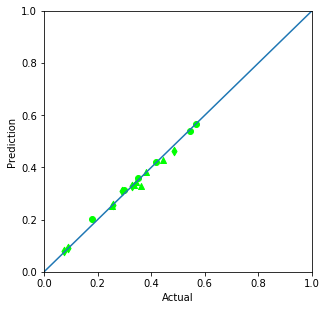

In [22]:
train_effects = [d for _, d in train_data.groupby('Effect')]
actual, pred, mse = get_predictions(model, train_effects)
plot_results(actual, pred)
mse

### Test results

#### Attraction

0.00397739483036359

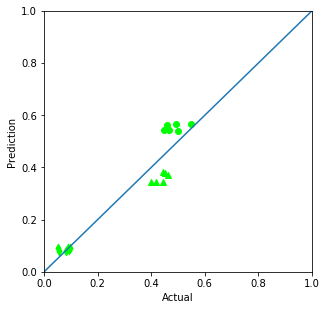

In [23]:
e1a_effects = [d for _, d in e1a.groupby('Effect')]
actual, pred, mse = get_predictions(model, [*e1a_effects])
plot_results(actual, pred)
np.mean(mse)

#### Compromise

0.00393109726226318

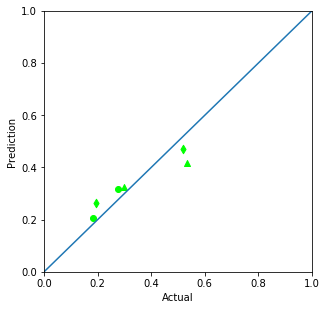

In [24]:
e1b_effects = [d for _, d in e1b.groupby('Effect')]
actual, pred, mse = get_predictions(model, [*e1b_effects])
plot_results(actual, pred)
np.mean(mse)

#### Similarity

0.004475572726753049

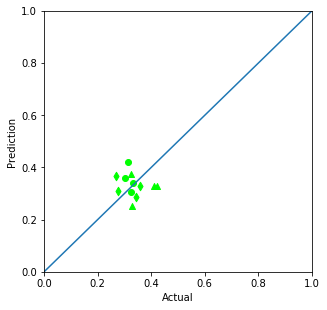

In [25]:
e1c_effects = [d for _, d in e1c.groupby('Effect')]
actual, pred, mse = get_predictions(model, [*e1c_effects])
plot_results(actual, pred)
np.mean(mse)

# Paper results

In [26]:
cols = ['Cond', 'Time', 'Resp.O1', 'Resp.O2', 'Resp.O3']
def load_paper_data(path):
    with open(path) as f:
        data = json.load(f)
    data = [[s[k] for k in cols] for u in data for s in u]
    data = pd.DataFrame(data=data, columns=cols)
    return data.rename(columns={'Cond': 'Effect'})

experimentData = {
    'e1a': (e1a, load_paper_data('out/e1a.pred.json')),
    'e1b': (e1b, load_paper_data('out/e1b.pred.json')),
    'e1c': (e1c, load_paper_data('out/e1c.pred.json')),
}

In [27]:

def get_paper_predictions(exp):
    actual, pred = experimentData[exp]    
    actual = [[k ,get_freq(d.response.values - 1)] for k, d in actual.groupby('Effect')]
    pred = [[k, d[['Resp.O1', 'Resp.O2', 'Resp.O3']].values.mean(0)] for k, d in pred.groupby('Effect')]
    actual = np.array([e[1] for e in sorted(actual, key=lambda x: x[0])])
    pred = np.array([e[1] for e in sorted(pred, key=lambda x: x[0])])
    mse = ((actual - pred) ** 2).mean(1)
    return actual, pred, mse.tolist()

#### Attraction

0.010754352170205516

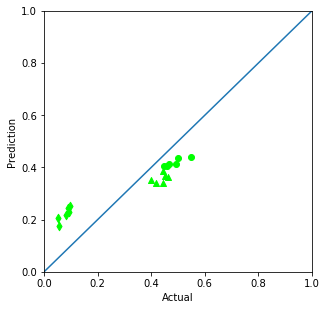

In [28]:
actual, pred, mse = get_paper_predictions('e1a')
plot_results(actual, pred)
np.mean(mse)

#### Compromise

0.018994590045915402

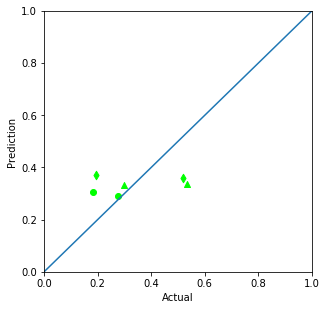

In [29]:
actual, pred, mse = get_paper_predictions('e1b')
plot_results(actual, pred)
np.mean(mse)

#### Similarity

0.001979431281793484

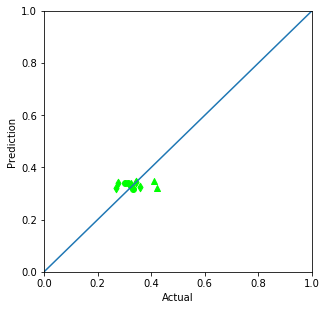

In [30]:
actual, pred, mse = get_paper_predictions('e1c')
plot_results(actual, pred)
np.mean(mse)